In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.neighbors import NearestNeighbors

%run -i '../analysis_utils.py'
%run -i '~/psix/utils/psix_functions.py'
%run -i '~/psix/utils/utils_functions.py'

100%|██████████| 202/202 [00:04<00:00, 41.08it/s]


Text(0.5, 0, 'feature selection')

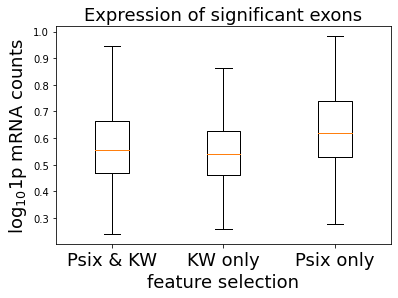

In [5]:
psix_pos = tiklova_psix.index[(tiklova_psix.qvals <= 0.05)]
kw_pos = tiklova_kw.index[(tiklova_kw.qvals <= 0.05)]
kw_only_pos = [x for x in kw_pos if x not in psix_pos]
psix_only_pos = [x for x in psix_pos if x not in kw_pos]

plt.boxplot(
    [np.log10(tiklova_mrna_event.loc[kw_pos | psix_pos]+1).mean(axis=1),
     np.log10(tiklova_mrna_event.loc[kw_only_pos]+1).mean(axis=1).dropna(),
     np.log10(tiklova_mrna_event.loc[psix_only_pos]+1).mean(axis=1).dropna()], showfliers=False)
plt.xticks([1, 2, 3], ['Psix & KW', 'KW only', 'Psix only'], fontsize=18)
plt.ylabel('log$_{10}$1p mRNA counts', fontsize=18)
plt.title('Expression of significant exons', fontsize=18)
plt.xlabel('feature selection', fontsize=18)

Text(0.5, 0, 'feature selection')

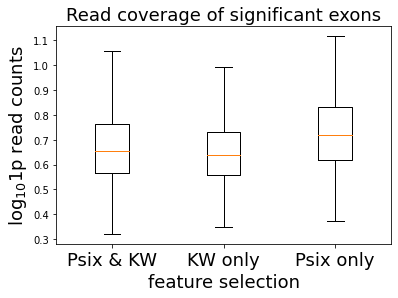

In [6]:
psix_pos = tiklova_psix.index[(tiklova_psix.qvals <= 0.05)]
kw_pos = tiklova_kw.index[(tiklova_kw.qvals <= 0.05)]
kw_only_pos = [x for x in kw_pos if x not in psix_pos]
psix_only_pos = [x for x in psix_pos if x not in kw_pos]

plt.boxplot(
    [np.log10(tiklova_sj_reads_adjusted.loc[kw_pos | psix_pos]+1).mean(axis=1),
     np.log10(tiklova_sj_reads_adjusted.loc[kw_only_pos]+1).mean(axis=1).dropna(),
     np.log10(tiklova_sj_reads_adjusted.loc[psix_only_pos]+1).mean(axis=1).dropna()], showfliers=False)
plt.xticks([1, 2, 3], ['Psix & KW', 'KW only', 'Psix only'], fontsize=18)
plt.ylabel('log$_{10}$1p read counts', fontsize=18)
plt.title('Read coverage of significant exons', fontsize=18)
plt.xlabel('feature selection', fontsize=18)

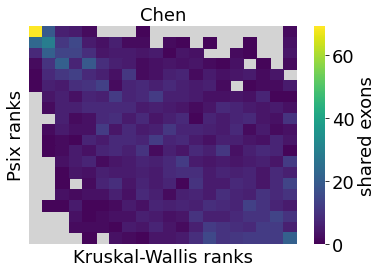

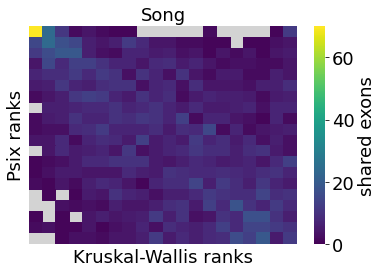

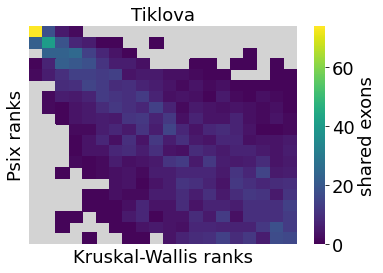

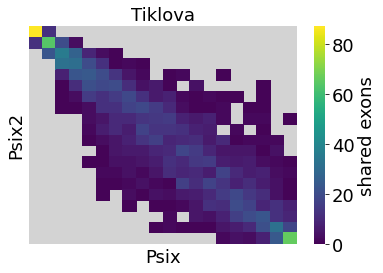

In [7]:
chen_comparison, chen_comparison_exons = plot_ranks(chen_kw, chen_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Chen')

song_comparison, song_comparison_exons = plot_ranks(song_kw, song_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Song')

tiklova_comparison, tiklova_comparison_exons = plot_ranks(tiklova_kw, tiklova_psix, 'KW_score', 'L_score', bins=20, 
                                          name1='Kruskal-Wallis ranks', name2='Psix ranks', title='Tiklova')


tiklova_comparison2, tiklova_comparison_exons2 = plot_ranks(tiklova_psix, tiklova_psix2, 'L_score', 'L_score', bins=20, 
                                          name1='Psix', name2='Psix2', title='Tiklova')

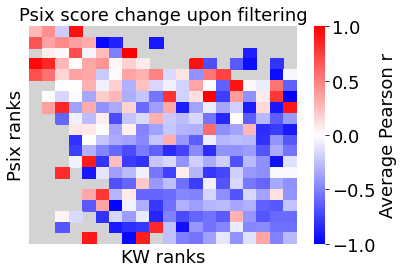

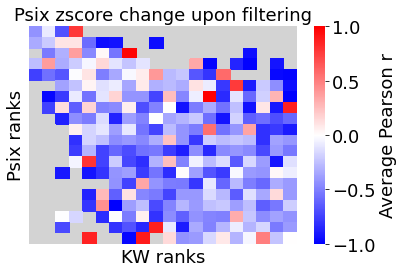

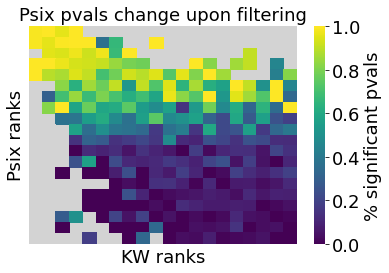

In [8]:
plot_correlations_per_rank(psix_comparison, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix score change upon filtering')

plot_correlations_per_rank(psix_comparison_z, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix zscore change upon filtering')

plot_correlations_per_rank(psix_comparison_pvals, tiklova_comparison_exons, tiklova_comparison, method = 'pvalues', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='Psix pvals change upon filtering')

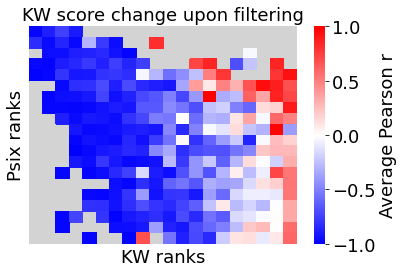

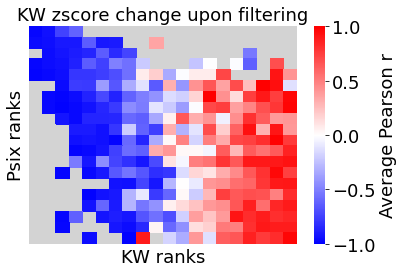

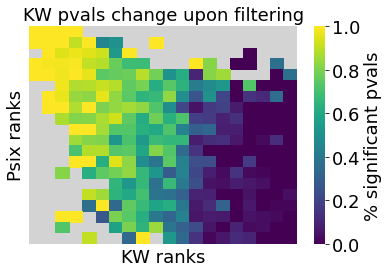

In [9]:
plot_correlations_per_rank(kw_comparison, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW score change upon filtering')

plot_correlations_per_rank(kw_comparison_z, tiklova_comparison_exons, tiklova_comparison, method = 'pearson', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW zscore change upon filtering')

plot_correlations_per_rank(kw_comparison_pvals, tiklova_comparison_exons, tiklova_comparison, method = 'pvalues', 
                               xlabel = 'KW ranks', ylabel='Psix ranks', title='KW pvals change upon filtering')

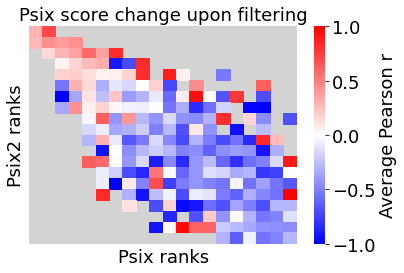

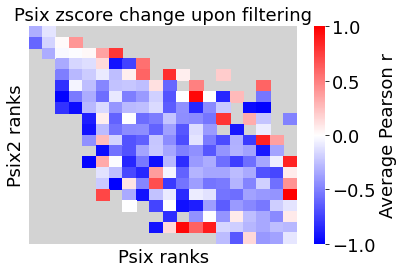

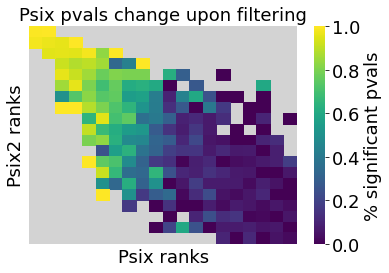

In [46]:
plot_correlations_per_rank(psix_comparison, tiklova_comparison_exons2, tiklova_comparison2, method = 'pearson', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix score change upon filtering')

plot_correlations_per_rank(psix_comparison_z, tiklova_comparison_exons2, tiklova_comparison2, method = 'pearson', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix zscore change upon filtering')

plot_correlations_per_rank(psix_comparison_pvals, tiklova_comparison_exons2, tiklova_comparison2, method = 'pvalues', 
                               xlabel = 'Psix ranks', ylabel='Psix2 ranks', title='Psix pvals change upon filtering')

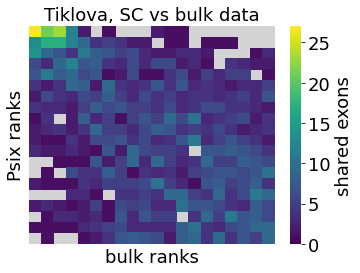

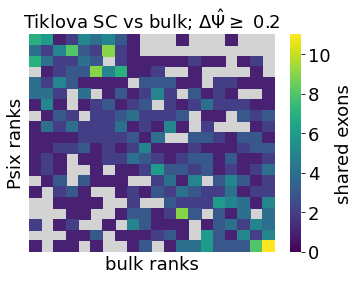

In [48]:
figsize(5.5,4)

comparison, comparison_exons = plot_ranks(weyn_rmats_fdr, tiklova_psix, 'fdr', 'L_score', bins=20, 
                                          name1='bulk ranks', name2='Psix ranks', title='Tiklova, SC vs bulk data')

x = weyn_rmats_fdr.index & weyn_ds.loc[weyn_ds.max(axis=1) >= 0.2].index

figsize(5.5,4)
tb_comparison, tb_comparison_exons = plot_ranks(weyn_rmats_fdr.loc[x], tiklova_psix, 'fdr', 'L_score', bins=20, 
                                          name1='bulk ranks', name2='Psix ranks', 
                                          title='Tiklova SC vs bulk; $\Delta \hat{\Psi} \geq$ 0.2')

In [5]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

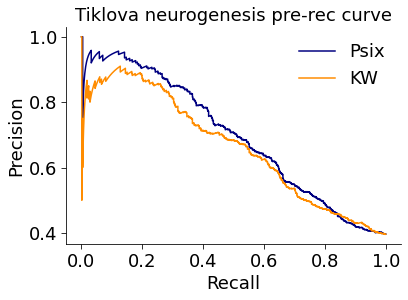

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

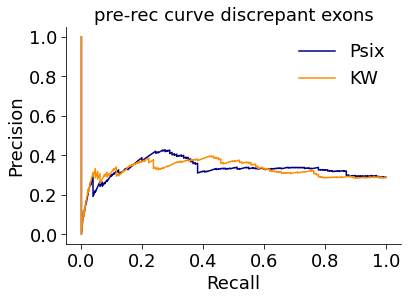

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = psix_only_pos + kw_only_pos
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('pre-rec curve discrepant exons', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)